# **Imports**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
ROOT_PATH = "/content/drive/MyDrive/My_Notebooks/Miniproject_DDPG/"

import sys
sys.path.append(ROOT_PATH)

from helpers import *
import torch
import numpy as np

# **Heuristic policy**

In [ ]:
openAI_env = gym.make('Pendulum-v1', g=9.81, new_step_api=True)
simulator = NormalizedEnv(openAI_env)

agent = RandomAgent(simulator)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# Function to execute an episode of 200 steps
def run_episode(simulator, agent):
  total_reward = 0
  initial_state = simulator.reset()
  action = agent.compute_action(initial_state)
  for step in range(200):
    next_state, reward, term, trunc, info = simulator.step(action)
    action = agent.compute_action(next_state)
    total_reward += reward
    # If trunc == True then simulator has served for the maximum amount of iterations
    if trunc == True:
      break
  return total_reward
  
runs = [run_episode(simulator, agent) for run in range(10)]
print("The total reward of a single run with random agent: ", runs[0])
print("The average total reward of 10 runs with random agent: ", np.sum(runs)/10.)

The total reward of a single run with random agent:  -930.6705567262452
The average total reward of 10 runs with random agent:  -1221.0038186827874


In [ ]:
class HeuristicPendulumAgent:
  def __init__(self, torque):
        self.torque = torque

  def velocity_sign(self, velocity):
    if velocity > 0:
      return 1.
    else:
      return -1.

  def compute_action(self, state):
    [cos_alpha, sin_alpha, angular_velocity] = state
    # In case pendulum is in the lower half 
    if cos_alpha < 0:
      torque = self.velocity_sign(angular_velocity) * self.torque
    # In case pendulum is in upper half
    else:
      torque = -1 * self.velocity_sign(angular_velocity) * self.torque
    return torque

  def compute_action_batch_naive(self, tensor):
    output = []
    for row in tensor:
      output.append([self.compute_action(row)])
    return output

  def compute_action_batch(self, tensor):
    x = tensor[:, 0:1]
    y = tensor[:, 1:2]
    angular_velocity = tensor[:, 2:3]
    torque = -1 * torch.sign(y) * torch.sign(angular_velocity) * self.torque
    return torque
        

In [ ]:
# Grid search for value of torque

torque_values = np.arange (0., 1., 0.005)
best_loss = -1000000000000
best_value = 0
for torque in torque_values:
    heuristic_agent = HeuristicPendulumAgent(torque)
    runs = [run_episode(simulator, heuristic_agent) for run in range(50)]
    average_loss = np.sum(runs)/50.
    if average_loss > best_loss:
      best_loss = average_loss
      best_value = torque
    #print("The average total reward of 50 runs with ", torque, " : ", average_loss)
print("best value: ", best_value, " best loss: ", best_loss)

best value:  0.88  best loss:  -411.47451610987997


In [ ]:
# Now use found parameter values

heuristic_agent = HeuristicPendulumAgent(0.88)
runs = [run_episode(simulator, heuristic_agent) for run in range(10)]
print("The total reward of a single run with heuristic agent: ", runs[0])
print("The average total reward of 10 runs with heuristic agent: ", np.sum(runs)/10.)

The total reward of a single run with heuristic agent:  -506.8652877212684
The average total reward of 10 runs with heuristic agent:  -410.47219708112016


# **Q function of the heuristic policy**

In [ ]:
# Configure working with GPU

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np


class ReplayBuffer(Dataset):
    def __init__(self, max_buffer_size: int):
        self.max_buffer_size = max_buffer_size
        # ReplayBuffer is used to store a sequence of transitions. A transition is a tuple (state, action, reward, next_state, trunc)
        # stored transitions are actually of the form: [state_x, state_y, state_velocity, action, reward, next_state_x, next_state_y, next_state_velocity, 1-int(trunc)]
        self.buffer = []

    def __len__(self):
        return len(self.buffer)
    
    def __getitem__(self, idx):
        return self.buffer[idx]

    def add_transition(self, state, action, reward, next_state, trunc, mode="delete oldest transitions"):
        if mode == "no deletion":
          if len(self.buffer) < self.max_buffer_size:
            self.buffer.append(np.array([state[0], state[1], state[2], action, reward, next_state[0], next_state[1], next_state[2], 1-int(trunc)], dtype="float32"))
        if mode == "delete oldest transitions":
          if len(self.buffer) < self.max_buffer_size:
            self.buffer.append(np.array([state[0], state[1], state[2], action, reward, next_state[0], next_state[1], next_state[2], 1-int(trunc)], dtype="float32"))
          else:
            self.buffer.pop(0)
            self.buffer.append(np.array([state[0], state[1], state[2], action, reward, next_state[0], next_state[1], next_state[2], 1-int(trunc)], dtype="float32"))

    def get_batch_of_transitions(self, batch_size):
      chosen_indices = np.random.choice(len(self.buffer), batch_size, replace=False)
      chosen_transitions = np.array([self.buffer[idx] for idx in chosen_indices])
      return torch.from_numpy(chosen_transitions)


class QNetwork(torch.nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()

        self.linear1 = torch.nn.Linear(4, 32)
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(32, 32)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(32, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        return x

In [ ]:
def TD_update_step_heuristic_policy(Q_network, batch_of_transitions, policy, criterion, optimizer, gamma=0.9):
  # split transition tensors in their parts
  state_and_action = batch_of_transitions[:, 0:4]
  reward = batch_of_transitions[:, 4:5]
  next_state = batch_of_transitions[:, 5:8]
  trunc = batch_of_transitions[:, 8:9]
  # clear the gradient
  optimizer.zero_grad()
  # compute the predicted Q-values and target Q-values
  Q_prediction = Q_network(state_and_action)
  with torch.no_grad():
    next_action = torch.Tensor(policy.compute_action_batch(next_state))
    next_state_and_next_action = torch.cat((next_state, next_action), 1)
    #Q_target = reward + (gamma * (Q_network(next_state_and_next_action) ))
    Q_target = reward + (gamma * (Q_network(next_state_and_next_action) * trunc))
  # compute the loss and the gradient
  loss = criterion(Q_target, Q_prediction)
  loss.backward()
  # update the weights of the QNetwork
  optimizer.step()
  return loss.item()

In [ ]:
# Train network to find Q-values of heuristic policy

# initialize agent and simulator
openAI_env = gym.make('Pendulum-v1', g=9.81, new_step_api=True)
simulator = NormalizedEnv(openAI_env)
heuristic_agent = HeuristicPendulumAgent(0.17)

# first step is to put some transition(s) in the buffer
buffer = ReplayBuffer(1e4)
state = simulator.reset()
for step in range(200):
  action = heuristic_agent.compute_action(state)
  next_state, reward, term, trunc, info = simulator.step(action)
  buffer.add_transition(state, action, reward, next_state, trunc)
  state = next_state
  # If trunc == True then simulator has served for the maximum amount of iterations (reached terminal state)
  if trunc == True:
    state = simulator.reset()

# initialize everything needed for training
train_dataloader = DataLoader(buffer, batch_size=128, shuffle=True)
Q_network = QNetwork()
Q_network.to(device)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(Q_network.parameters(), lr=1e-4)
episodes = 0
Q_network_losses = []
episode_losses = []
episode_loss = 0
gamma = 0.99
state = simulator.reset()

# training loop for the Q network
while episodes < 1000:
  # make a single transition and add it to the buffer
  action = heuristic_agent.compute_action(state)
  next_state, reward, term, trunc, info = simulator.step(action)
  buffer.add_transition(state, action, reward, next_state, trunc)
  state = next_state
  if trunc == True:
    episodes += 1
    state = simulator.reset()
    episode_losses.append(episode_loss/200)
    episode_loss = 0
  # sample a batch of transitions from the buffer and do the TD-learning update step
  batch_of_transitions = next(iter(train_dataloader)).to(device)
  loss = TD_update_step_heuristic_policy(Q_network, batch_of_transitions, heuristic_agent, criterion, optimizer, gamma)
  Q_network_losses.append(loss)
  episode_loss += loss

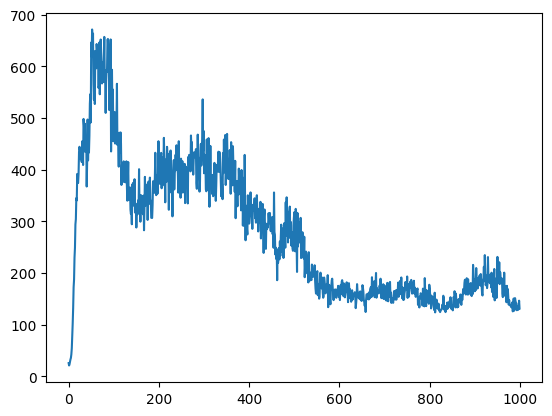

In [ ]:
# Plot the training curve of the Q network

import matplotlib.pyplot as plt
y_values = episode_losses
#y_values = Q_network_losses
#plt.figure(figsize=(10,12))#plt.axis([0, len(y_values), 0, 1400])
plt.plot(range(0, len(y_values)), y_values)
plt.show()

In [ ]:
# Save the Q network for the heuristic policy

torch.save(Q_network.state_dict(), ROOT_PATH + "Q_network_heuristic.pt")

In [ ]:
# Load the saved network (optional)

Q_network = QNetwork().to(device)
Q_network.load_state_dict(torch.load(ROOT_PATH + "Q_network_heuristic.pt"))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>

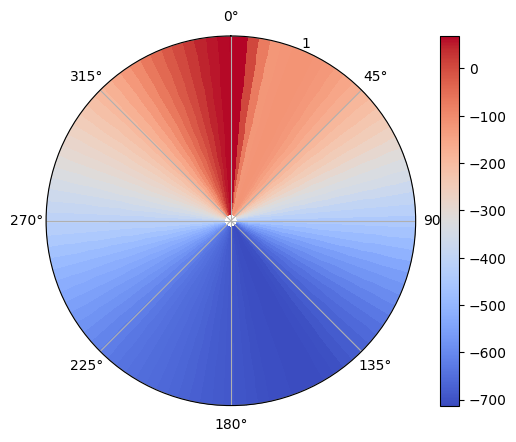

In [ ]:
# Plot the polar heat maps

import matplotlib.pyplot as plt
import numpy as np

chosen_velocity = -1.
chosen_torque = 0.88
Q_network = Q_network # trained earlier
def get_Q_value(angle):
  input = torch.Tensor([np.cos(angle), np.sin(angle), chosen_velocity, chosen_torque])
  return Q_network(input.to(device))

untrained_Q_network = QNetwork().to(device)
def get_untrained_Q_value(angle):
  input = torch.Tensor([np.cos(angle), np.sin(angle), chosen_velocity, chosen_torque])
  return untrained_Q_network(input.to(device))

# Create data
r = np.linspace(0, 2*np.pi-0.04, 100)
theta = np.linspace(0, 2*np.pi-0.04, 100)
R, Theta = np.meshgrid(r, theta)
#Z = np.cos(R)
Z = torch.Tensor(R).apply_(get_Q_value)
#Z2 = torch.Tensor(R).apply_(get_untrained_Q_value)

# create plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
mesh = ax.pcolormesh(r, theta, Z, cmap='coolwarm')
#ax2 = fig.add_subplot(111, projection='polar')
#mesh2 = ax2.pcolormesh(r, theta, Z2, cmap='Greys')

# settings
ax.set_rlim(0, 1)
ax.set_rticks([ 1.0])
#ax.set_rlabel_position(22.5)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
fig.colorbar(mesh)

# Show final plot
plt.show()


# **Minimal implementation of DDPG**

In [ ]:
class PolicyNetwork(torch.nn.Module):
  def __init__(self):
      super(PolicyNetwork, self).__init__()

      self.linear1 = torch.nn.Linear(3, 32)
      self.activation1 = torch.nn.ReLU()
      self.linear2 = torch.nn.Linear(32, 32)
      self.activation2 = torch.nn.ReLU()
      self.linear3 = torch.nn.Linear(32, 1)
      self.activation3 = torch.nn.Tanh()

  def forward(self, x):
      x = self.linear1(x)
      x = self.activation1(x)
      x = self.linear2(x)
      x = self.activation2(x)
      x = self.linear3(x)
      x = self.activation3(x)
      return x


class GaussianActionNoise():
  def __init__(self, std=1.):
    self.std_of_Gaussian = std

  def get_noisy_action(self, action):
    noise = np.random.normal(loc=0., scale=self.std_of_Gaussian)
    return np.clip(action + noise, a_min=-1., a_max=1.)


class DDPGAgent():
  def __init__(self, gamma, Q_network_lr, policy_network_lr, device, noise_std, trained_Q_net=None, trained_policy_net=None):
    # networks
    self.Q_net = QNetwork().to(device)
    self.policy_net = PolicyNetwork().to(device)
    # other handy stuff
    self.gaussian_action_noise = GaussianActionNoise(std=noise_std)
    self.gamma = gamma
    self.Q_net_optimizer = torch.optim.Adam(self.Q_net.parameters(), lr=Q_network_lr)
    self.Q_net_criterion = torch.nn.MSELoss()
    self.policy_net_optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=policy_network_lr)
    self.device = device
    # to create agent with pretrained networks 
    if trained_Q_net != None:
      self.Q_net = trained_Q_net.to(device)
    if trained_policy_net != None:
      self.policy_net = trained_policy_net.to(device)

  def compute_action(self, state, deterministic=True):
    action = self.policy_net(torch.Tensor(state).to(self.device)).item()
    if deterministic:
      return action
    else:
      return self.gaussian_action_noise.get_noisy_action(action)

  def TD_update_step_Q_network(self, batch_of_transitions):
    # expects batch_of_transitions to already be on the same device as self.device
    # split transition tensors in their parts
    state_and_action = batch_of_transitions[:, 0:4]
    reward = batch_of_transitions[:, 4:5]
    next_state = batch_of_transitions[:, 5:8]
    trunc = batch_of_transitions[:, 8:9]
    # clear the gradient
    self.Q_net_optimizer.zero_grad()
    # compute the predicted Q-values and target Q-values
    Q_prediction = self.Q_net(state_and_action)
    with torch.no_grad():
      next_action = self.policy_net(next_state)
      next_state_and_next_action = torch.cat((next_state, next_action), 1)
      #Q_target = reward + (self.gamma * (self.Q_net(next_state_and_next_action) ))
      Q_target = reward + (self.gamma * (self.Q_net(next_state_and_next_action) * trunc))
    # compute the loss and the gradient
    loss = self.Q_net_criterion(Q_target, Q_prediction)
    loss.backward()
    # update the weights of the QNetwork
    self.Q_net_optimizer.step()
    return loss.item()

  def update_step_policy_network(self, batch_of_states):
    # expects batch_of_states to already be on the same device as self.device
    # clear the gradient
    self.policy_net_optimizer.zero_grad()
    # compute actions and then Q-values
    actions = self.policy_net(batch_of_states)
    states_and_actions = torch.cat((batch_of_states, actions), 1)
    Q_values = self.Q_net(states_and_actions)
    # compute loss and the gradient
    loss = -1 * torch.mean(Q_values)
    loss.backward()
    # update the parameters of the policy network
    self.policy_net_optimizer.step()
    return loss.item()

In [ ]:
# Train Q network to find Q values of the policy and train the policy network itself

# initialize DDPG agent and simulator
openAI_env = gym.make('Pendulum-v1', g=9.81, new_step_api=True)
simulator = NormalizedEnv(openAI_env)
agent = DDPGAgent(gamma=0.99, Q_network_lr=1e-4, policy_network_lr=1e-4, device=device, noise_std=0.3)

# first step is to create the buffer and put some transition(s) in it
buffer = ReplayBuffer(1e5)
state = simulator.reset()
for step in range(200):
  action = agent.compute_action(state, deterministic=False)
  next_state, reward, term, trunc, info = simulator.step(action)
  buffer.add_transition(state, action, reward, next_state, trunc)
  state = next_state
  # If trunc == True then simulator has served for the maximum amount of iterations (reached terminal state)
  if trunc == True:
    state = simulator.reset()

# initialize everything needed for training
state = simulator.reset()
train_dataloader = DataLoader(buffer, batch_size=128, shuffle=True)
episodes = 0
Q_network_losses = []
Q_network_episode_losses = []
policy_network_losses = []
policy_network_episode_losses = []
cummulative_rewards = []
Q_network_episode_loss = 0
policy_network_episode_loss = 0
cummulative_reward = 0

# training loop for the Q network
while episodes < 1000:
  # make a single transition and add it to the buffer
  action = agent.compute_action(state, deterministic=False)
  next_state, reward, term, trunc, info = simulator.step(action)
  buffer.add_transition(state, action, reward, next_state, trunc)
  state = next_state
  cummulative_reward += reward
  if trunc == True:
    episodes += 1
    state = simulator.reset()
    Q_network_episode_losses.append(Q_network_episode_loss/200)
    Q_network_episode_loss = 0
    policy_network_episode_losses.append(Q_network_episode_loss/200)
    policy_network_episode_loss = 0
    cummulative_rewards.append(cummulative_reward)
    cummulative_reward = 0
  # sample a batch of transitions from the buffer and update the Q network and policy network
  batch_of_transitions = next(iter(train_dataloader)).to(device)
  Q_network_loss = agent.TD_update_step_Q_network(batch_of_transitions)
  batch_of_states = batch_of_transitions[:, 0:3]
  policy_network_loss = agent.update_step_policy_network(batch_of_states)
  Q_network_losses.append(Q_network_loss)
  Q_network_episode_loss += Q_network_loss
  policy_network_losses.append(policy_network_loss)
  policy_network_episode_loss += policy_network_loss

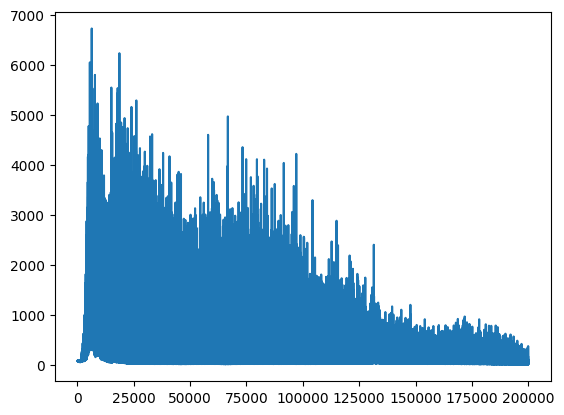

In [ ]:
# Plot the training curve of the Q network

import matplotlib.pyplot as plt
#y_values = Q_network_episode_losses
y_values = Q_network_losses
#plt.figure(figsize=(10,12))#plt.axis([0, len(y_values), 0, 1400])
plt.plot(range(0, len(y_values)), y_values)
plt.show()

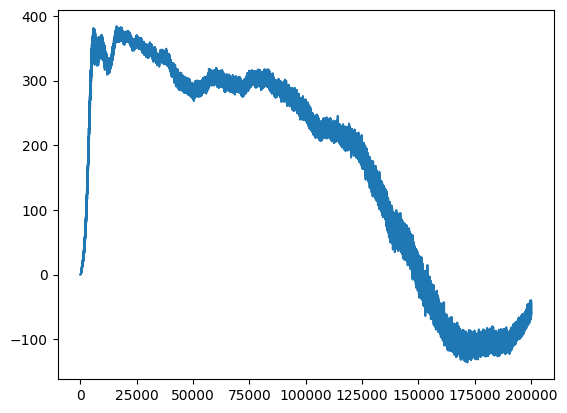

In [ ]:
# Plot the loss of the policy network

y_values = policy_network_losses
#plt.figure(figsize=(10,12))#plt.axis([0, len(y_values), 0, 1400])
plt.plot(range(0, len(y_values)), y_values)
plt.show()

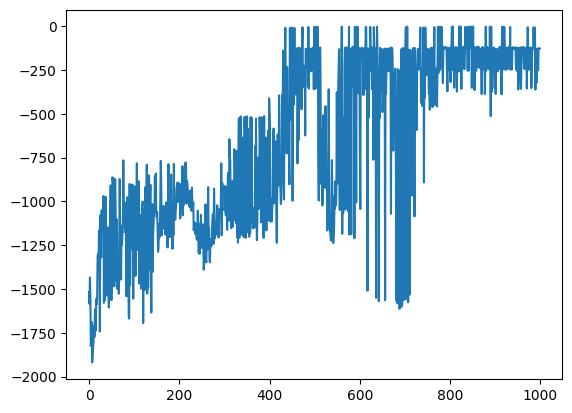

In [ ]:
# Plot the cummulative reward of each episode

y_values = cummulative_rewards
#plt.figure(figsize=(10,12))#plt.axis([0, len(y_values), 0, 1400])
plt.plot(range(0, len(y_values)), y_values)
plt.show()

In [ ]:
# Save the Q network and the policy network

torch.save(agent.Q_net.state_dict(), ROOT_PATH + "Q_net.pt")
torch.save(agent.policy_net.state_dict(), ROOT_PATH + "policy_net.pt")

In [ ]:
# Create a new agent equipped with loaded pretrained Q and policy networks (optional)

trained_Q_network = QNetwork()
trained_Q_network.load_state_dict(torch.load(ROOT_PATH + "Q_net.pt"))
trained_policy_network = PolicyNetwork()
trained_policy_network.load_state_dict(torch.load(ROOT_PATH + "policy_net.pt"))
agent = DDPGAgent(gamma=0.99, Q_network_lr=1e-4, policy_network_lr=1e-4, device=device, noise_std=0.3, trained_Q_net=trained_Q_network, trained_policy_net=trained_policy_network)

In [ ]:
# Execute some test episodes

cummulative_rewards = []
for episode in range(100):
  cummulative_reward = 0
  state = simulator.reset()
  for step in range(200):
    action = agent.compute_action(state, deterministic=True)
    next_state, reward, term, trunc, info = simulator.step(action)
    buffer.add_transition(state, action, reward, next_state, trunc)
    state = next_state
    cummulative_reward += reward
    # If trunc == True then simulator has served for the maximum amount of iterations (reached terminal state)
    if trunc == True:
      state = simulator.reset()
  cummulative_rewards.append(cummulative_reward)
average_cummulative_reward = np.mean(cummulative_rewards)
print("average cummulative reward: ", average_cummulative_reward)


KeyboardInterrupt: ignored

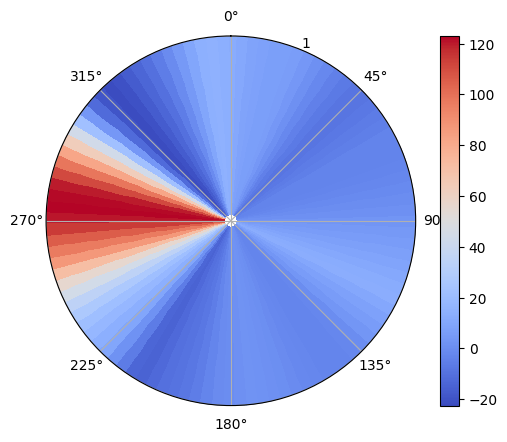

In [ ]:
# Plot polar heatmaps

import matplotlib.pyplot as plt
import numpy as np

chosen_velocity = 5.
chosen_torque = 0.88
def get_Q_value(angle):
  input = torch.Tensor([np.cos(angle), np.sin(angle), chosen_velocity, chosen_torque])
  return agent.Q_net(input.to(device))

untrained_Q_network = QNetwork().to(device)
def get_untrained_Q_value(angle):
  input = torch.Tensor([np.cos(angle), np.sin(angle), chosen_velocity, chosen_torque])
  return untrained_Q_network(input.to(device))

# Create data
r = np.linspace(0, 2*np.pi-0.04, 100)
theta = np.linspace(0, 2*np.pi-0.04, 100)
R, Theta = np.meshgrid(r, theta)
#Z = np.cos(R)
Z = torch.Tensor(R).apply_(get_Q_value)

# create plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
mesh = ax.pcolormesh(r, theta, Z, cmap='coolwarm')

# settings
ax.set_rlim(0, 1)
ax.set_rticks([ 1.0])
#ax.set_rlabel_position(22.5)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
fig.colorbar(mesh)

# Show final plot
plt.show()

# **Target networks**